In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import warnings

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,age,education,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,...,company_type_MNC,company_type_Mid-size,company_type_Small,company_type_Startup,emi_scenario_Education EMI,emi_scenario_Home Appliances EMI,emi_scenario_Personal Loan EMI,emi_scenario_Vehicle EMI,house_type_Own,house_type_Rented
0,38.0,0,11.321777,0.641854,9.903538,0.055408,0.055408,0.000000,0.00000,8.881975,...,0,1,0,0,0,0,1,0,0,1
1,38.0,1,9.975855,2.079442,0.000000,-0.874653,-0.874653,8.537192,0.00000,7.244942,...,1,0,0,0,0,0,0,0,0,0
2,38.0,0,11.363276,1.916923,0.000000,0.985470,0.985470,0.000000,0.00000,9.230241,...,0,0,0,1,1,0,0,0,1,0
3,58.0,2,11.109473,1.163151,0.000000,1.915531,1.915531,9.341456,0.00000,8.732466,...,0,1,0,0,0,0,0,1,1,0
4,48.0,0,10.956073,1.481605,0.000000,0.985470,0.985470,9.148571,9.69591,8.188967,...,0,1,0,0,0,1,0,0,0,0


In [3]:
df.columns

Index(['age', 'education', 'monthly_salary', 'years_of_employment',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'requested_amount',
       'requested_tenure', 'emi_eligibility', 'max_monthly_emi',
       'debt_to_income', 'expense_to_income', 'employment_stability_score',
       'credit_risk_score', 'savings_buffer_ratio', 'gender_Male',
       'marital_status_Single', 'employment_type_Private',
       'employment_type_Self-employed', 'company_type_MNC',
       'company_type_Mid-size', 'company_type_Small', 'company_type_Startup',
       'emi_scenario_Education EMI', 'emi_scenario_Home Appliances EMI',
       'emi_scenario_Personal Loan EMI', 'emi_scenario_Vehicle EMI',
       'house_type_Own', 'house_type_Rented'],
      dtype='object')

In [4]:
X = df.drop(['max_monthly_emi','emi_eligibility'], axis = 1)
y = df['emi_eligibility']


rfc_model = RandomForestClassifier(n_estimators=200, random_state=42)
rfc_model.fit(X,y)


features_importance_df = pd.DataFrame({
    'Features':X.columns,
    'Importance':rfc_model.feature_importances_
})


features_importance_df = features_importance_df.sort_values(by = 'Importance', ascending= False)

features_importance_df


,Features,Importance
17,requested_amount,0.222331
20,expense_to_income,0.135605
18,requested_tenure,0.094546
2,monthly_salary,0.068923
10,groceries_utilities,0.039343
15,bank_balance,0.034730
19,debt_to_income,0.032820
9,travel_expenses,0.029715
14,credit_score,0.029671
13,current_emi_amount,0.028165


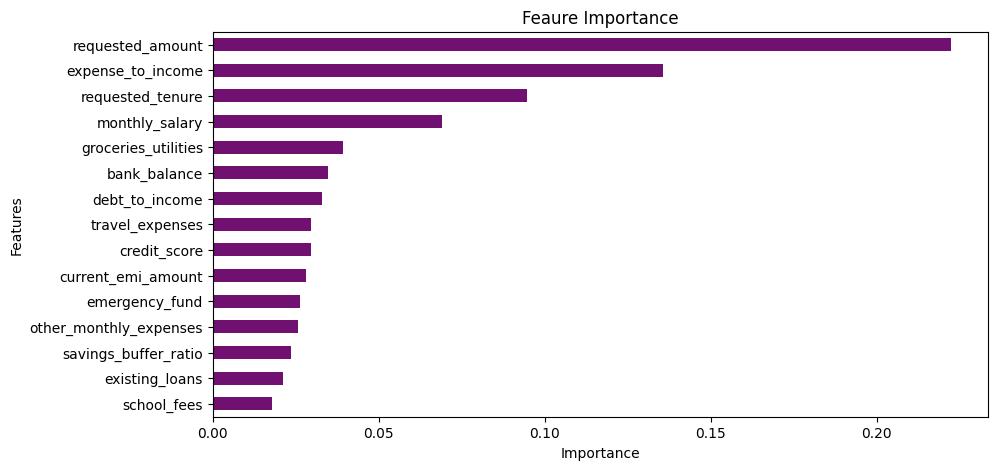

In [5]:
plt.figure(figsize = (10,5))
sns.barplot(x = features_importance_df['Importance'][:15], y = features_importance_df['Features'][:15], color = 'purple', width = 0.5)
plt.title("Feaure Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


In [6]:
features_importance_df['Cumulative'] =  features_importance_df['Importance'].cumsum()
top_features = features_importance_df[features_importance_df['Cumulative']<=0.9]['Features'].tolist()
print(top_features)

['requested_amount', 'expense_to_income', 'requested_tenure', 'monthly_salary', 'groceries_utilities', 'bank_balance', 'debt_to_income', 'travel_expenses', 'credit_score', 'current_emi_amount', 'emergency_fund', 'other_monthly_expenses', 'savings_buffer_ratio', 'existing_loans', 'school_fees', 'college_fees', 'years_of_employment', 'employment_stability_score', 'monthly_rent']


In [7]:
c_df = df[top_features]

In [8]:
c_df['target'] = df['emi_eligibility']

In [9]:
c_df.to_csv("classification_data.csv", index = False)

Model Training

In [10]:
df = pd.read_csv("classification_data.csv")
df.head()

,requested_amount,expense_to_income,requested_tenure,monthly_salary,groceries_utilities,bank_balance,debt_to_income,travel_expenses,credit_score,current_emi_amount,emergency_fund,other_monthly_expenses,savings_buffer_ratio,existing_loans,school_fees,college_fees,years_of_employment,employment_stability_score,monthly_rent,target
0,13.652993,0.725182,2.772589,11.321777,9.878221,12.622151,0.242131,8.881975,-0.587540,9.903538,11.159118,9.488048,4.520581,1,0.000000,0.00000,0.641854,0.9,9.903538,2
1,11.759793,0.716279,2.995732,9.975855,8.594339,11.434975,0.190698,7.244942,0.182299,8.318986,10.199919,8.160804,5.553488,1,8.537192,0.00000,2.079442,7.0,0.000000,2
2,12.631344,0.413473,2.833213,11.363276,9.873080,13.407619,0.000000,9.230241,-0.730103,0.000000,12.497252,8.699681,10.832172,0,0.000000,0.00000,1.916923,5.8,0.000000,0
3,12.624786,0.559880,4.363099,11.109473,9.384378,12.996576,0.000000,8.732466,-0.231133,0.000000,12.090106,8.974745,9.266467,0,9.341456,0.00000,1.163151,2.2,0.000000,0
4,12.437188,0.934555,2.079442,10.956073,9.692828,11.485565,0.000000,8.188967,0.980651,0.000000,10.247113,8.999743,2.190227,0,9.148571,9.69591,1.481605,3.4,0.000000,2


In [11]:
X = df.drop(['target'], axis = 1)
y = df['target']

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [13]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Probabilities for ROC-AUC (multiclass)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    else:
        roc_auc = np.nan
    
    # Metrics (multiclass compatible)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Store results
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

# Summary table sorted by F1-Score
results_df = pd.DataFrame(results).T.sort_values(by='F1-Score', ascending=False)
results_df.round(4)

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
XGBoost,0.9580,0.9518,0.9580,0.9524,0.9954
Random Forest,0.9368,0.9308,0.9368,0.9178,0.9895
Decision Tree,0.9092,0.9126,0.9092,0.9109,0.9005
Logistic Regression,0.9143,0.8756,0.9143,0.8945,0.9729
K-Nearest Neighbors,0.8840,0.8627,0.8840,0.8719,0.9265


Cross validation

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define the model
clf = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation (accuracy)
cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f'All 5-Fold Accuracy Scores: {cv_scores}\n')
print(f'Mean Accuracy Score: {np.mean(cv_scores):.4f}')


All 5-Fold Accuracy Scores: [0.95647542 0.95717021 0.95723197 0.95662982 0.95717021]

Mean Accuracy Score: 0.9569


Hyperparameter Tunning

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

X_train = X_train.astype('float32')
y_train = y_train.astype('int')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

model = XGBClassifier(tree_method='hist', n_jobs=2)

search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1
)

search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [17]:
best_params = search.best_params_
best_params

{'subsample': 0.8,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

MLFLOW

In [19]:
mlflow.set_tracking_uri("http://127.0.0.1:5000") 

mlflow.set_experiment("EMI_Eligibility")

2025/10/07 00:15:11 INFO mlflow.tracking.fluent: Experiment with name 'EMI_Eligibility' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/779683918941972457', creation_time=1759776311821, experiment_id='779683918941972457', last_update_time=1759776311821, lifecycle_stage='active', name='EMI_Eligibility', tags={}>

In [20]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train a model and log it to MLflow
    """
    with mlflow.start_run(run_name=model_name):
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        if hasattr(model, 'get_params'):
            params = model.get_params()
            for param, value in params.items():
                mlflow.log_param(param, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        return accuracy, mlflow.active_run().info.run_id

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "XGBoost Classifier": XGBClassifier(n_estimators=200, use_label_encoder=False, 
                                        eval_metric='logloss', random_state=42)
}

best_accuracy = 0
best_model_name = ""
best_run_id = ""

# Train and compare all models
for name, model in models.items():
    accuracy, run_id = train_and_log_model(model, name, X_train, y_train, X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_run_id = run_id

print(f"\nBest Model: {best_model_name} with accuracy: {best_accuracy:.4f}")

2025/10/07 00:17:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 00:17:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Accuracy: 0.9143, F1: 0.8945
🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/3c3fc44355cc41f49d5a584a977a6e97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457


2025/10/07 00:19:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 00:19:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-Neighbors Classifier - Accuracy: 0.8840, F1: 0.8719
🏃 View run K-Neighbors Classifier at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/7660bac6ed27431998c531226ee23bef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457


2025/10/07 00:19:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 00:19:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree Classifier - Accuracy: 0.9092, F1: 0.9109
🏃 View run Decision Tree Classifier at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/227238b2b13d4340814ff61f9d1ee9bb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457


2025/10/07 00:22:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 00:22:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Classifier - Accuracy: 0.9381, F1: 0.9197
🏃 View run Random Forest Classifier at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/52df9c1c62d64539be2b3983c081ff71
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457


2025/10/07 00:24:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 00:24:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost Classifier - Accuracy: 0.9580, F1: 0.9524
🏃 View run XGBoost Classifier at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/72506ae16c0d467bb3b4ddf74dcbdfd1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457

Best Model: XGBoost Classifier with accuracy: 0.9580


In [22]:
def cross_validation_with_mlflow(model, model_name, X, y, cv=5):
    """
    Perform cross-validation and log results to MLflow
    """
    with mlflow.start_run(run_name=f"{model_name}_CrossValidation"):
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("cv_folds", cv)
        
        # Log metrics
        mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
        mlflow.log_metric("cv_std_accuracy", cv_scores.std())
        
        for i, score in enumerate(cv_scores):
            mlflow.log_metric(f"fold_{i+1}_accuracy", score)
        
        # Train on full data and log model
        model.fit(X, y)
        mlflow.sklearn.log_model(model, "model")
        
        print(f"{model_name} CV Results:")
        print(f"  Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        print(f"  Individual Folds: {cv_scores}")
        
        return cv_scores.mean(), mlflow.active_run().info.run_id

In [ ]:
def hyperparameter_tuning_with_mlflow(model, param_grid, X_train, y_train, X_test, y_test, 
                                       search_type='grid', cv=5,n_jobs=1,n_iter=10):
    """
    Perform hyperparameter tuning and log to MLflow
    search_type: 'grid' for GridSearchCV or 'random' for RandomizedSearchCV
    """
    
    parent_run_name = f"HyperparameterTuning_{model.__class__.__name__}"
    
    with mlflow.start_run(run_name=parent_run_name) as parent_run:
        
        # Choose search method
        if search_type == 'grid':
            search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', 
                                 n_jobs=n_jobs, verbose=1)
        else:
            search = RandomizedSearchCV(model, param_grid, cv=cv, scoring='accuracy',
                                       n_iter=n_iter, n_jobs=n_jobs, verbose=1, random_state=42)
        
        # Fit search
        search.fit(X_train, y_train)
        
        # Log parent run info
        mlflow.log_param("search_type", search_type)
        mlflow.log_param("cv_folds", cv)
        mlflow.log_param("n_jobs",n_jobs)
        mlflow.log_param("param_grid", str(param_grid))
        
        # Log best parameters and score
        mlflow.log_params(search.best_params_)
        mlflow.log_metric("best_cv_score", search.best_score_)
        
        # Evaluate on test set
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_f1_score", test_f1)
        
        # Log best model
        mlflow.sklearn.log_model(best_model, "best_model")
        
        # Log all CV results as nested runs
        cv_results = pd.DataFrame(search.cv_results_)
        for idx, row in cv_results.iterrows():
            with mlflow.start_run(run_name=f"config_{idx}", nested=True):
                # Log parameters for this configuration
                params = {k.replace('param_', ''): v for k, v in row.items() 
                         if k.startswith('param_')}
                mlflow.log_params(params)
                
                # Log metrics
                mlflow.log_metric("mean_test_score", row['mean_test_score'])
                mlflow.log_metric("std_test_score", row['std_test_score'])
                mlflow.log_metric("rank", row['rank_test_score'])
        
        print(f"\nBest Parameters: {search.best_params_}")
        print(f"Best CV Score: {search.best_score_:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        
        return best_model, search.best_params_, parent_run.info.run_id

In [37]:
from xgboost import XGBClassifier

# Reduced parameter grid for faster tuning
param_grid_xgb_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

best_xgb_clf, best_params_clf, tuning_run_id_clf = hyperparameter_tuning_with_mlflow(
    XGBClassifier(random_state=42, eval_metric='logloss', tree_method='hist'),
    param_grid_xgb_clf,
    X_train, y_train, X_test, y_test,
    search_type='random',  
    cv=3,
    n_iter=15
    # Remove both parent_run_name and n_jobs - they're not supported
)

print(f"Best Parameters: {best_params_clf}")
print(f"Tuning Run ID: {tuning_run_id_clf}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


2025/10/07 11:44:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 11:44:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run config_0 at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/e110665f78ab41979ce5cfe3256225aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457
🏃 View run config_1 at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/4dcb57ad495f40c49d18688d003faca4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457
🏃 View run config_2 at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/c63211d4c8684dfda2788070c231a909
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457
🏃 View run config_3 at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/925ee9009bf04fc481d47a71aafec5f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457
🏃 View run config_4 at: http://127.0.0.1:5000/#/experiments/779683918941972457/runs/fb9ba16fb96f401788aa2077a9c45e88
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/779683918941972457
🏃 View run config_5 at: http:/

In [38]:
# 5. REGISTER BEST MODEL


def register_best_model(run_id, model_name="MyBestModel"):
    """
    Register the best model to MLflow Model Registry
    """
    model_uri = f"runs:/{run_id}/model"
    
    # Register model
    model_details = mlflow.register_model(model_uri, model_name)
    
    print(f"Model registered: {model_name}")
    print(f"Version: {model_details.version}")
    
    return model_details

In [39]:
# ============================================
# 6. LOAD MODEL FROM MLFLOW
# ============================================

def load_model_from_mlflow(run_id=None, model_name=None, version=None):
    """
    Load a model from MLflow
    Option 1: Load by run_id
    Option 2: Load by model_name and version from registry
    """
    if run_id:
        # Load by run_id
        model_uri = f"runs:/{run_id}/model"
        model = mlflow.sklearn.load_model(model_uri)
        print(f"Model loaded from run: {run_id}")
    
    elif model_name and version:
        # Load from registry
        model_uri = f"models:/{model_name}/{version}"
        model = mlflow.sklearn.load_model(model_uri)
        print(f"Model loaded from registry: {model_name} version {version}")
    
    else:
        raise ValueError("Provide either run_id or (model_name and version)")
    
    return model



In [ ]:

loaded_model = load_model_from_mlflow(run_id=tuning_run_id_clf)

loaded_model = load_model_from_mlflow(model_name="MyBestClassifier", version=1)


predictions = loaded_model.predict(X_test)